# House Prices
#### Samuel Rueesch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import HuberRegressor

### 1. Data Cleaning

In [2]:
df = pd.read_csv("house-prices.csv")

In [3]:
df.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000


In [4]:
df = df.drop(["Order", "PID"], axis=1)

In [5]:
#df.info()

In [6]:
df.select_dtypes("int64").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 26 columns):
MS SubClass        2430 non-null int64
Lot Area           2430 non-null int64
Overall Qual       2430 non-null int64
Overall Cond       2430 non-null int64
Year Built         2430 non-null int64
Year Remod/Add     2430 non-null int64
1st Flr SF         2430 non-null int64
2nd Flr SF         2430 non-null int64
Low Qual Fin SF    2430 non-null int64
Gr Liv Area        2430 non-null int64
Full Bath          2430 non-null int64
Half Bath          2430 non-null int64
Bedroom AbvGr      2430 non-null int64
Kitchen AbvGr      2430 non-null int64
TotRms AbvGrd      2430 non-null int64
Fireplaces         2430 non-null int64
Wood Deck SF       2430 non-null int64
Open Porch SF      2430 non-null int64
Enclosed Porch     2430 non-null int64
3Ssn Porch         2430 non-null int64
Screen Porch       2430 non-null int64
Pool Area          2430 non-null int64
Misc Val           2430 non-null in

In [7]:
# Change integer columns to float.

s = df.select_dtypes(include='int64').columns
df[s] = df[s].astype("float64")

In [8]:
# Create subframes for numeric and object columns.

df_float=df.select_dtypes(exclude=['object'])
df_object=df.select_dtypes("object")

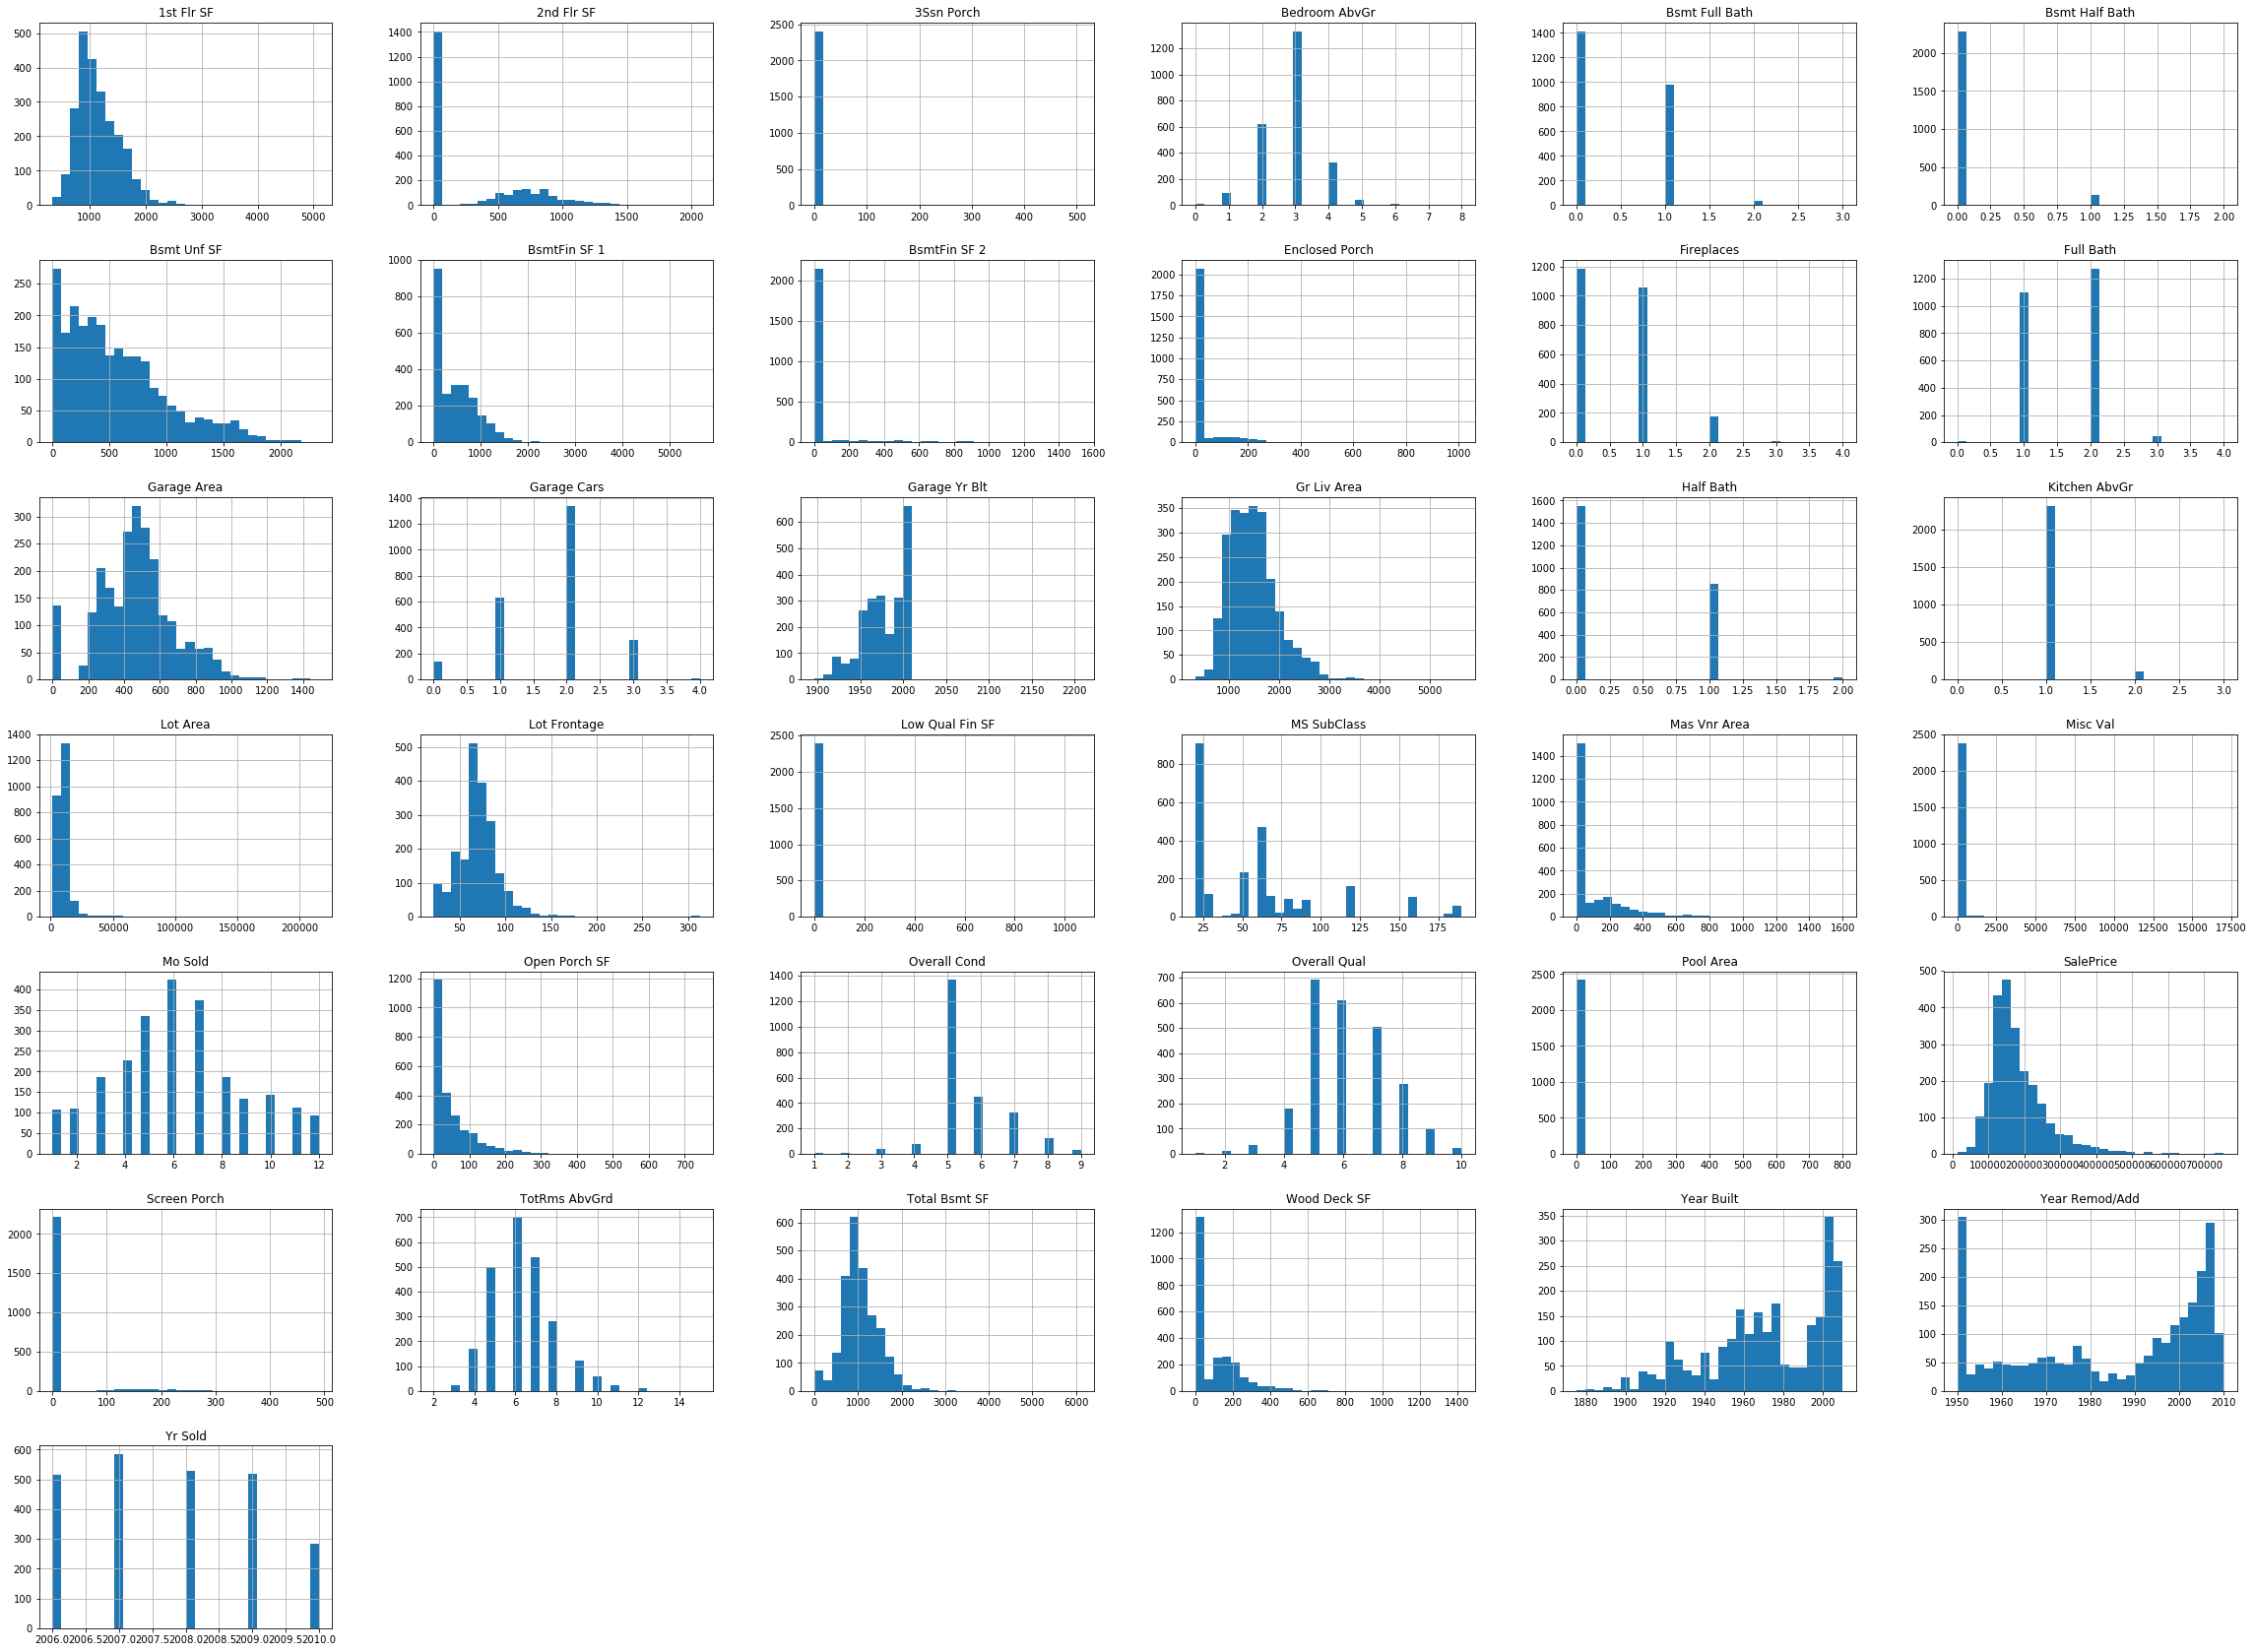

In [9]:
df_float.hist(bins=30, figsize=(40, 30))
plt.show()

&emsp; 
#### The following features had a couple of outlies. By doing a very quick online research I tried to come up with a cutoff rate for each of them

In [10]:
# Cleaning "Lot Area". Only 4 above 100000. 

df_float = df_float.drop(df_float[df_float["Lot Area"]> 100000].index)

# Cleaning "3Ssn Porch". Only 7 over 250 

df_float = df_float.drop(df_float[df_float["3Ssn Porch"]> 250].index)

# Cleaning "Enclosed Porch". Only 4 above 350. 

df_float = df_float.drop(df_float[df_float["Enclosed Porch"]> 350].index)
         
# Cleaning "Low Qual Fin SF". Only 6 above 500. 

df_float = df_float.drop(df_float[df_float["Low Qual Fin SF"]> 500].index)

# Cleaning "Misc Val". Only 7 above 3500. 

df_float = df_float.drop(df_float[df_float["Misc Val"]> 3500].index)
         
# Cleaning "Pool Area". Only 2 above 600. 

df_float = df_float.drop(df_float[df_float["Pool Area"]> 600].index)
         
# Cleaning "Screen Porch". Only 6 above 350. 

df_float = df_float.drop(df_float[df_float["Screen Porch"]> 350].index)

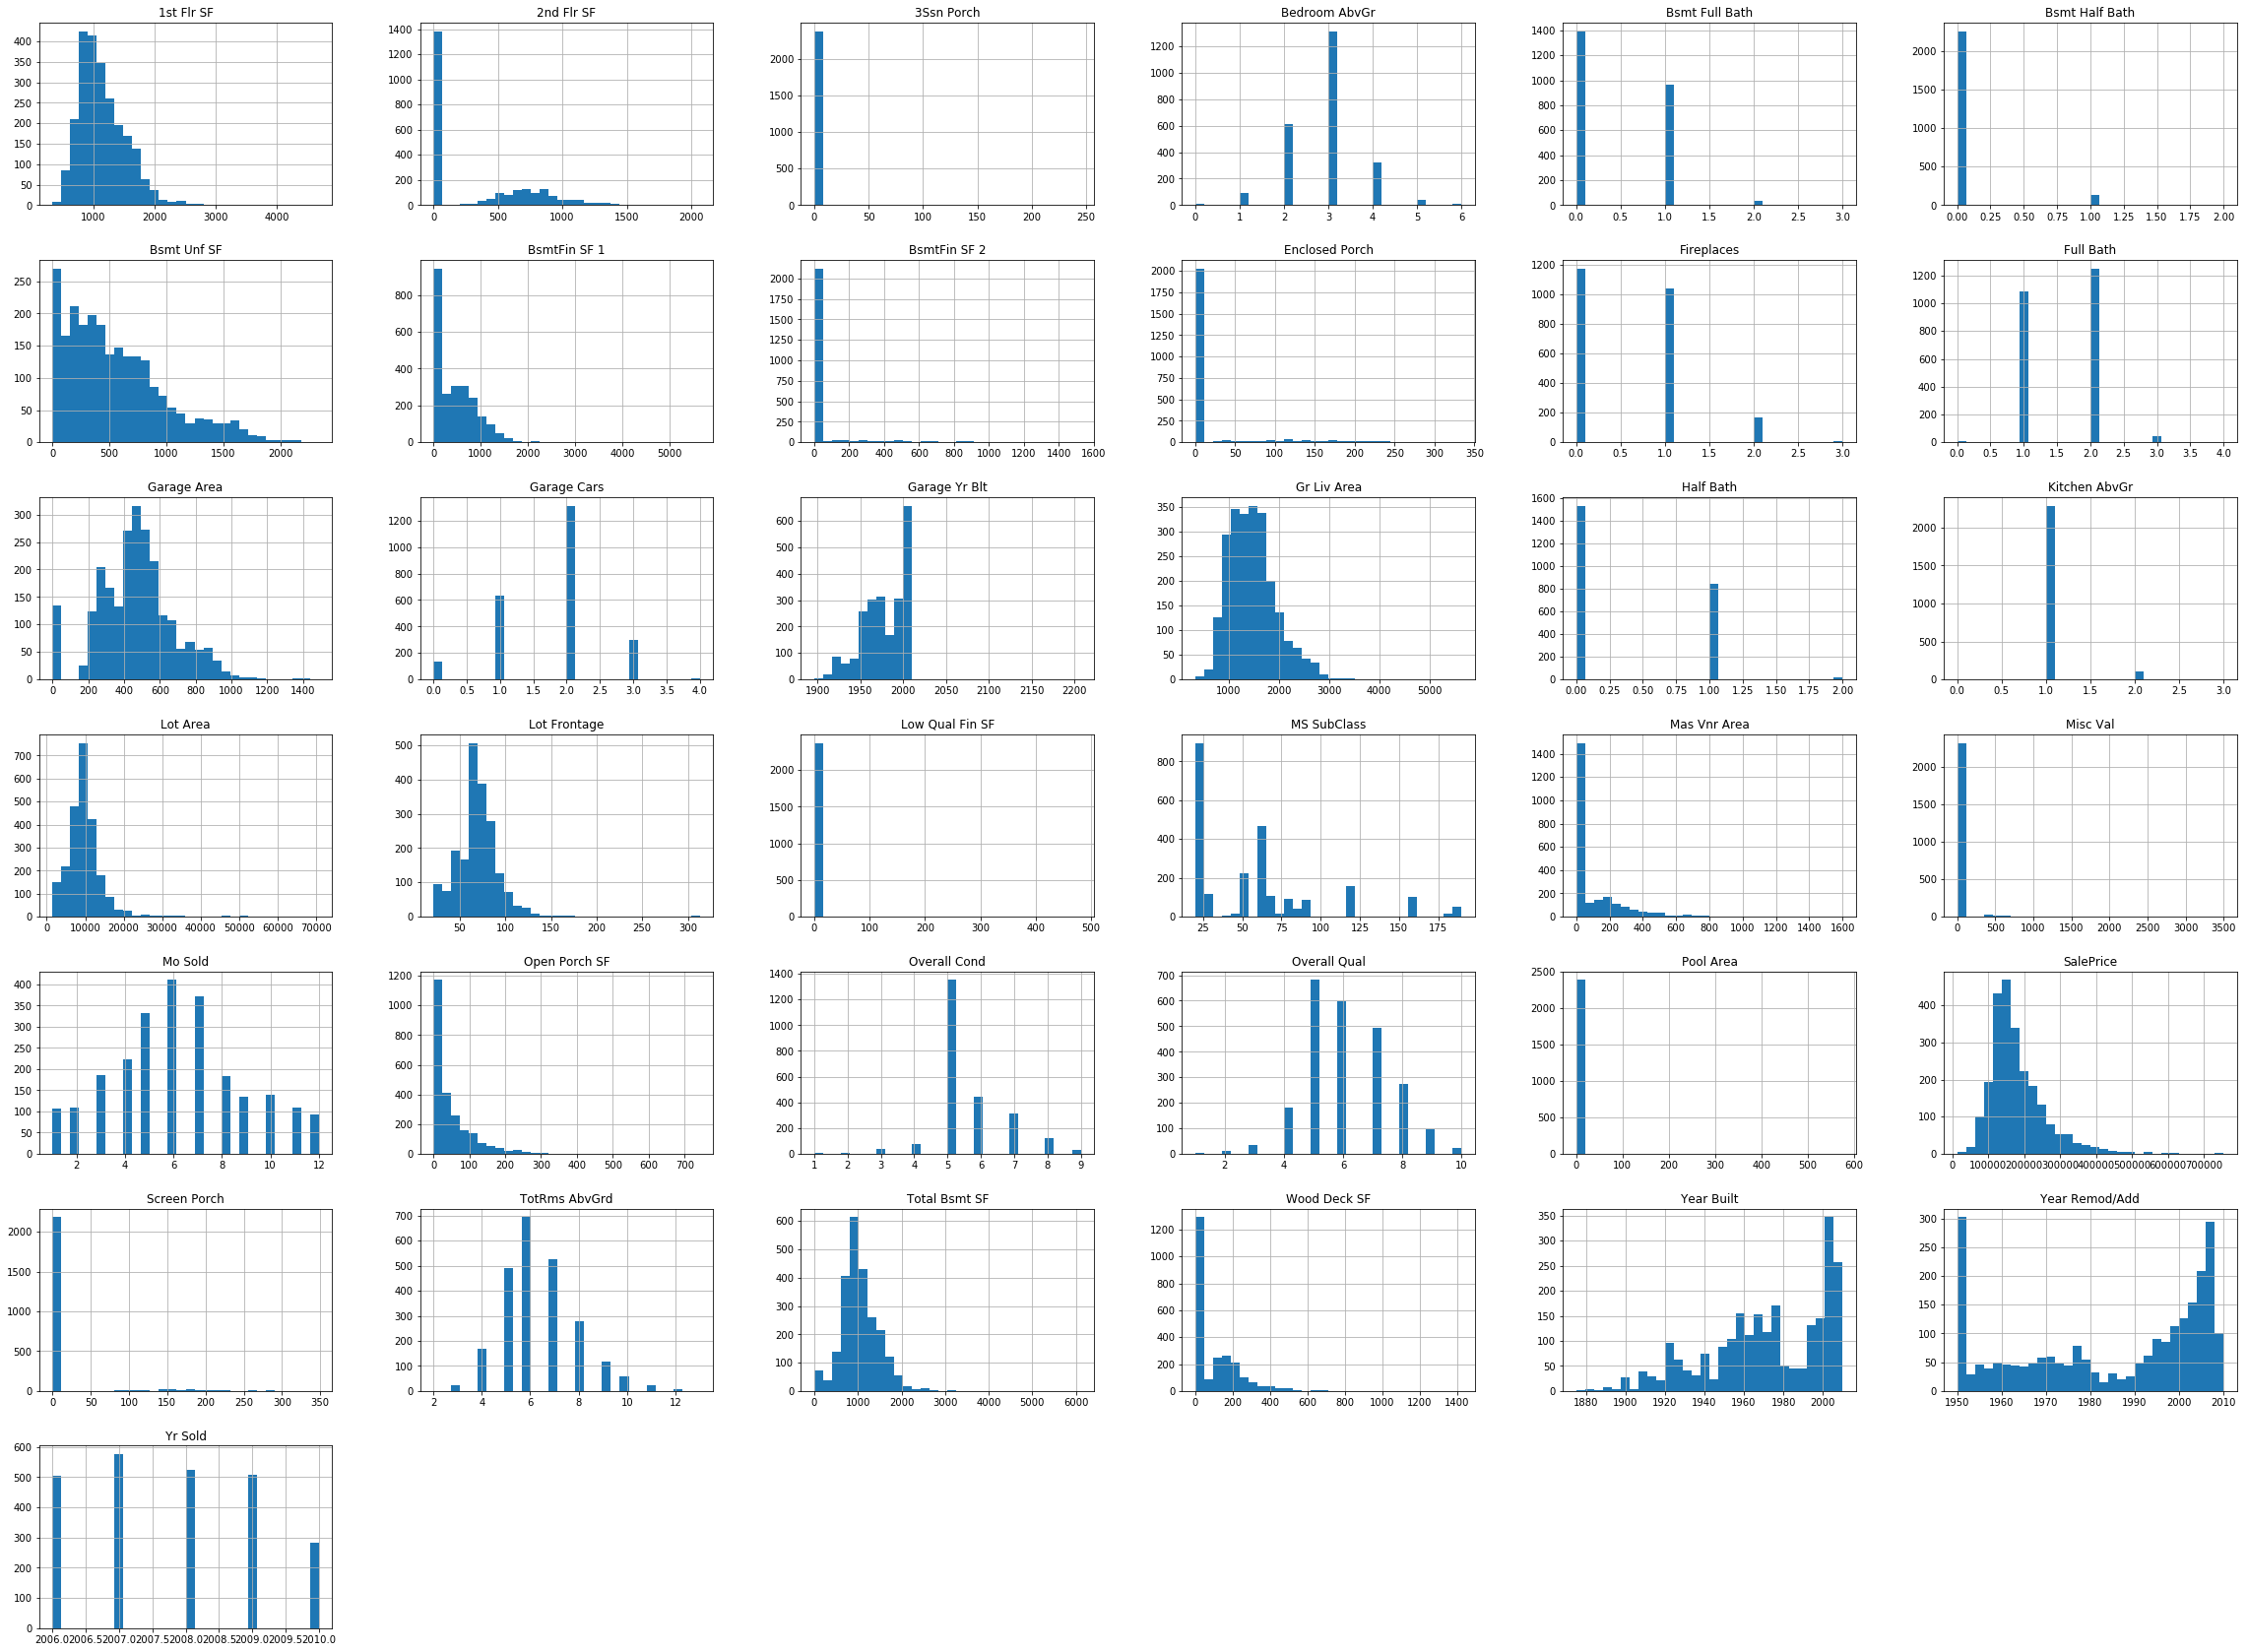

In [11]:
df_float.hist(bins=30, figsize=(40, 30))
plt.show()

In [12]:
# Cap the max year built to 2020

df_float["Garage Yr Blt"] = df_float["Garage Yr Blt"].where(df_float["Garage Yr Blt"] < 2020, np.nan) 
df_float["Garage Yr Blt"].describe().T

count    2257.000000
mean     1977.826761
std        25.136518
min      1896.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2010.000000
Name: Garage Yr Blt, dtype: float64

In [13]:
# Dealing with null values.

df_float.isnull().sum().sort_values(ascending=False).head(15)

Lot Frontage      409
Garage Yr Blt     137
Mas Vnr Area       20
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Cars         1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
Garage Area         1
BsmtFin SF 1        1
Gr Liv Area         0
Year Remod/Add      0
Year Built          0
Overall Cond        0
dtype: int64

In [14]:
is_NaN = df_float. isnull()
row_has_NaN = is_NaN. any(axis=1)
df_float[row_has_NaN].head(5)

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,60.0,NaN,8795.0,7.0,5.0,2000.0,2000.0,0.0,300.0,0.0,...,224.0,54.0,0.0,0.0,0.0,0.0,0.0,4.0,2009.0,236000.0
13,30.0,NaN,12342.0,4.0,5.0,1940.0,1950.0,0.0,262.0,0.0,...,158.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2009.0,82500.0
16,90.0,50.0,9350.0,5.0,5.0,1975.0,1975.0,0.0,864.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2008.0,99600.0
26,60.0,NaN,10382.0,7.0,6.0,1973.0,1973.0,240.0,859.0,32.0,...,235.0,204.0,228.0,0.0,0.0,0.0,350.0,11.0,2009.0,200000.0
34,70.0,NaN,56600.0,5.0,1.0,1900.0,1950.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2008.0,103000.0


In [15]:
# Coulmns that can be replaced with 0.  suppose that Nan values were initally meant as 0.

data_nan = ["Lot Frontage","Mas Vnr Area", "Bsmt Full Bath", 
                "Bsmt Half Bath", "BsmtFin SF 1", "Total Bsmt SF", 
                "Bsmt Unf SF", "BsmtFin SF 2", "Garage Cars", "Garage Area"]

df_float.loc[:,data_nan] = df_float.loc[:, data_nan].replace(np.nan,0)

# Missing year built values can be replace with the mean.

df_float.loc[:,"Garage Yr Blt"] = df_float.loc[:,"Garage Yr Blt"].fillna(df_float.loc[:,"Garage Yr Blt"].mean(axis=0))

df_float.isnull().sum().sort_values(ascending=False).head(15)

SalePrice          0
Bsmt Half Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Total Bsmt SF      0
Bsmt Unf SF        0
BsmtFin SF 2       0
BsmtFin SF 1       0
Mas Vnr Area       0
Year Remod/Add     0
Year Built         0
Overall Cond       0
Overall Qual       0
dtype: int64

In [16]:
# Change features with a lot of 0s to categorical. 

df_float['3Ssn Porch'] = np.where(df_float['3Ssn Porch']>0.1, 'Yes', "No")
df_float['Low Qual Fin SF'] = np.where(df_float['Low Qual Fin SF']>0.1, 'Yes', "No")
df_float['Misc Val'] = np.where(df_float['Misc Val']>0.1, 'Yes', "No")
df_float['Pool Area'] = np.where(df_float['Pool Area']>0.1, 'Yes', "No")
df_float['Screen Porch'] = np.where(df_float['Screen Porch']>0.1, 'Yes', "No")

In [17]:
df_object.isnull().sum().sort_values(ascending=False).head(20)

Pool QC           2418
Misc Feature      2340
Alley             2267
Fence             1941
Fireplace Qu      1186
Garage Cond        138
Garage Qual        138
Garage Finish      138
Garage Type        136
Bsmt Exposure       74
BsmtFin Type 2      72
BsmtFin Type 1      71
Bsmt Qual           71
Bsmt Cond           71
Mas Vnr Type        20
Electrical           1
Condition 2          0
Condition 1          0
Neighborhood         0
Land Slope           0
dtype: int64

In [18]:
# Drop columns that miss more than 50% of entries

df_object = df_object.drop(["Pool QC", "Misc Feature", "Alley", "Fence", "Fireplace Qu"], axis=1)

In [19]:
# Compare unique values with the documentation to detect wrong entries. 

df_object.describe().T

,count,unique,top,freq
MS Zoning,2430,7,RL,1894
Street,2430,2,Pave,2419
Lot Shape,2430,4,Reg,1514
Land Contour,2430,4,Lvl,2176
Utilities,2430,3,AllPub,2427
Lot Config,2430,5,Inside,1774
Land Slope,2430,3,Gtl,2312
Neighborhood,2430,28,NAmes,361
Condition 1,2430,9,Norm,2086
Condition 2,2430,8,Norm,2403


In [20]:
# Check what the least frequent values are to see if there are any mispellings. 

for col in df_object.columns:
    last_frequent = df_object[col].value_counts().tail(2)
    print(last_frequent)
# I couldn't find any wrong entries. 

A (agr)    2
I (all)    2
Name: MS Zoning, dtype: int64
Pave    2419
Grvl      11
Name: Street, dtype: int64
IR2    66
IR3    14
Name: Lot Shape, dtype: int64
HLS    98
Low    54
Name: Land Contour, dtype: int64
NoSewr    2
NoSeWa    1
Name: Utilities, dtype: int64
FR2    72
FR3    11
Name: Lot Config, dtype: int64
Mod    102
Sev     16
Name: Land Slope, dtype: int64
GrnHill    2
Landmrk    1
Name: Neighborhood, dtype: int64
RRNn    8
RRNe    5
Name: Condition 1, dtype: int64
RRAe    1
RRAn    1
Name: Condition 2, dtype: int64
Duplex    86
2fmCon    56
Name: Bldg Type, dtype: int64
1.5Unf    16
2.5Fin     7
Name: House Style, dtype: int64
Mansard    8
Shed       5
Name: Roof Style, dtype: int64
ClyTile    1
Membran    1
Name: Roof Matl, dtype: int64
PreCast    1
ImStucc    1
Name: Exterior 1st, dtype: int64
CBlock     2
PreCast    1
Name: Exterior 2nd, dtype: int64
BrkCmn    21
CBlock     1
Name: Mas Vnr Type, dtype: int64
Ex    87
Fa    31
Name: Exter Qual, dtype: int64
Ex    12
Po   

In [21]:
# Check missing values

df_object.isnull().sum().sort_values(ascending = False).head(15)

Garage Cond       138
Garage Qual       138
Garage Finish     138
Garage Type       136
Bsmt Exposure      74
BsmtFin Type 2     72
Bsmt Cond          71
Bsmt Qual          71
BsmtFin Type 1     71
Mas Vnr Type       20
Electrical          1
Sale Condition      0
Bldg Type           0
Condition 2         0
Condition 1         0
dtype: int64

In [22]:
# By consultating the documentation I saw that I could change the NaN to the category NA.

data_NA = ["Garage Cond", "Garage Qual", "Garage Finish", 
           "Garage Type", "BsmtFin Type 2", "Bsmt Cond", "Bsmt Qual","BsmtFin Type 1", "Bsmt Exposure"]

df_object[data_NA]=df_object[data_NA].fillna("NA")

In [23]:
# By consultating the documentation I saw that I could change the NaN to the category None.

df_object["Mas Vnr Type"]=df_object["Mas Vnr Type"].fillna("None")

In [24]:
# Replace the missing value with the most frequent value of the feature. 

df_object["Electrical"]=df_object["Electrical"].fillna("SBrkr")

In [25]:
# Replace NA in some features to the most common value TA.

df_object[["Garage Qual", "Garage Cond", "Bsmt Cond", "Bsmt Qual"]]=df_object[["Garage Qual", "Garage Cond", "Bsmt Cond", "Bsmt Qual"]].replace("NA", "TA")

In [26]:
# No missing values.

df_object.isnull().sum().sort_values(ascending = False).head(3)

Sale Condition    0
Condition 2       0
Mas Vnr Type      0
dtype: int64

In [27]:
# Merging df_float and df_object together

df_clean = pd.concat([df_float, df_object], axis=1, join='inner')

In [28]:
df_clean.isnull().sum().sort_values(ascending = False).head(3)

Sale Condition    0
Full Bath         0
Bedroom AbvGr     0
dtype: int64

### 2. Feature Encoding

In [29]:
# Discrete Variables

discrete = ["Year Built", "Year Remod/Add", "Bsmt Full Bath", 
            "Bsmt Half Bath", "Full Bath", "Half Bath", "TotRms AbvGrd",
            "Fireplaces", "Garage Yr Blt", "Garage Cars", "Mo Sold", "Yr Sold"]

df_discrete=df_clean[discrete]

In [30]:
df_discrete.head(5)

,Year Built,Year Remod/Add,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Mo Sold,Yr Sold
0,2000.0,2000.0,0.0,0.0,2.0,1.0,8.0,1.0,2000.0,2.0,4.0,2009.0
1,1951.0,1951.0,0.0,0.0,1.0,1.0,5.0,1.0,1951.0,2.0,6.0,2006.0
2,1970.0,1970.0,0.0,0.0,1.0,1.0,6.0,0.0,1970.0,1.0,1.0,2007.0
3,1959.0,1959.0,0.0,1.0,1.0,1.0,6.0,1.0,1959.0,2.0,4.0,2010.0
4,1910.0,1950.0,0.0,0.0,1.0,1.0,9.0,1.0,1960.0,1.0,1.0,2007.0


I decided to apply a cyclical encoding to the Mo Sold feature. Altough, this particular feature doesn't really add a lot of value to the perfomance of the model

In [31]:
import math

# Cyclical encoding on "Mo Sold"
# Normalize values to match with the 0-2 pi cycle.

mo_normalized = 2* math.pi * df_discrete["Mo Sold"] / df_discrete["Mo Sold"].max()

df_discrete["Mo Sold cos"] = np.cos(mo_normalized)
df_discrete["Mo Sold sin"] = np.sin(mo_normalized)

df_discrete = df_discrete.drop("Mo Sold", axis=1)

/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [32]:
# Nominal Variables

nominal =['3Ssn Porch', 'Low Qual Fin SF', 'Misc Val', 'Pool Area', 'Screen Porch',
          "MS SubClass", "MS Zoning", "Street", "Land Contour", "Lot Config", 
          "Neighborhood", "Condition 1", "Condition 2", "Bldg Type", "House Style", 
          "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", 
          "Foundation", "Heating", "Central Air", "Garage Type", "Sale Type", "Sale Condition"]

df_nominal=df_clean[nominal]

In [33]:
# Change MS SubClass to string.

df_nominal["MS SubClass"] = df_nominal["MS SubClass"].astype(str)

df_nominal["MS SubClass"].describe()

/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


count     2394
unique      16
top       20.0
freq       896
Name: MS SubClass, dtype: object

In [34]:
# Get Dummies

df_nominal = pd.get_dummies(df_nominal, drop_first=True)
df_nominal.head(5)

,3Ssn Porch_Yes,Low Qual Fin SF_Yes,Misc Val_Yes,Pool Area_Yes,Screen Porch_Yes,MS SubClass_150.0,MS SubClass_160.0,MS SubClass_180.0,MS SubClass_190.0,MS SubClass_20.0,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [35]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [36]:
ohe = OneHotEncoder(sparse=False)

In [37]:
# Ordinal Variables 

ordinal = ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond", "Exter Qual",
           "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", 
           "Heating QC", "Electrical", "Kitchen Qual", "Functional", "Garage Finish", 
           "Garage Qual", "Garage Cond", "Paved Drive"]

df_ordinal=df_clean[ordinal]

In [38]:
# Lot Shape Ordinal

lot_dict = { "Reg" : 4,
            "IR1" : 3,
            "IR2" : 2,
            "IR3" : 1}
df_ordinal["Lot Shape Ordinal"] = df_ordinal["Lot Shape"].map(lot_dict)


# Utilities Ordinal

utilities_dict = { "AllPub" : 4,
            "NoSewr" : 3,
            "NoSeWa" : 2,
            "ELO" : 1}
df_ordinal["Utilities Ordinal"] = df_ordinal["Utilities"].map(utilities_dict)


# Land Slope Ordinal

land_dict = { "Gtl" : 3,
            "Mod" : 2,
            "Sev" : 1,}
df_ordinal["Land Slope Ordinal"] = df_ordinal["Land Slope"].map(land_dict)


# Exter Qual Ordinal

exter_qual_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}
df_ordinal["Exter Qual Ordinal"] = df_ordinal["Exter Qual"].map(exter_qual_dict)


# Exter Cond Ordinal

exter_cond_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_ordinal["Exter Cond Ordinal"] = df_ordinal["Exter Cond"].map(exter_cond_dict)


# Bsmt Qual Ordinal

bsmt_qual_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_ordinal["Bsmt Qual Ordinal"] = df_ordinal["Bsmt Qual"].map(bsmt_qual_dict)


# Bsmt Cond Ordinal

bsmt_cond_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_ordinal["Bsmt Cond Ordinal"] = df_ordinal["Bsmt Cond"].map(bsmt_qual_dict)


# Bsmt Exposure Ordinal

bsmt_expo_dict = { "Gd" : 5,
                    "Av" : 4,
                    "Mn" : 3,
                      "No" : 2,
                      "NA" : 1}

df_ordinal["Bsmt Exposure Ordinal"] = df_ordinal["Bsmt Exposure"].map(bsmt_expo_dict)


# BsmtFin Type 1 Ordinal

bsmt_t1_dict = { "GLQ" : 7,
                    "ALQ" : 6,
                    "BLQ" : 5,
                    "Rec" : 4,
                    "LwQ" : 3,
                    "Unf" : 2,
                    "NA" : 1}

df_ordinal["BsmtFin Type 1 Ordinal"] = df_ordinal["BsmtFin Type 1"].map(bsmt_t1_dict)


# BsmtFin Type 2 Ordinal

bsmt_t2_dict = { "GLQ" : 7,
                    "ALQ" : 6,
                    "BLQ" : 5,
                    "Rec" : 4,
                    "LwQ" : 3,
                    "Unf" : 2,
                    "NA" : 1}

df_ordinal["BsmtFin Type 2 Ordinal"] = df_ordinal["BsmtFin Type 2"].map(bsmt_t2_dict)


# Heating QC Ordinal

heating_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_ordinal["Heating QC Ordinal"] = df_ordinal["Heating QC"].map(heating_dict)


# Electrical Ordinal

electrical_dict = { "SBrkr" : 5,
                    "FuseA" : 4,
                    "FuseF" : 3,
                      "FuseP" : 2,
                      "Mix" : 1}

df_ordinal["Electrical Ordinal"] = df_ordinal["Electrical"].map(electrical_dict)


# Kitchen Qual Ordinal

kitchen_qual_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_ordinal["Kitchen Qual Ordinal"] = df_ordinal["Kitchen Qual"].map(kitchen_qual_dict)


# Functional Ordinal

functional_dict = { "Typ" : 8,
                    "Min1" : 7,
                    "Min2" : 6,
                    "Mod" : 5,
                    "Maj1" : 4,
                    "Maj2" : 3,
                    "Sev" : 2,
                    "Sal" : 1}

df_ordinal["Functional Ordinal"] = df_ordinal["Functional"].map(functional_dict)


# Garage Finish Ordinal

garage_finish_dict = { "Fin" : 4,
                       "RFn" : 3,
                       "Unf" : 2,
                       "NA" : 1}

df_ordinal["Garage Finish Ordinal"] = df_ordinal["Garage Finish"].map(garage_finish_dict)


# Garage Qual Ordinal

garage_qual_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_ordinal["Garage Qual Ordinal"] = df_ordinal["Garage Qual"].map(garage_qual_dict)


# Garage Cond Ordinal

garage_cond_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_ordinal["Garage Cond Ordinal"] = df_ordinal["Garage Cond"].map(garage_cond_dict)


# Paved Drive Ordinal

paved_dict = { "Y" : 3,
                "P" : 2,
                "N" : 1}

df_ordinal["Paved Drive Ordinal"] = df_ordinal["Paved Drive"].map(paved_dict)

/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [39]:
df_ordinal = df_ordinal.drop(["Lot Shape", "Utilities", "Land Slope", "Exter Qual", "Exter Cond", "Bsmt Qual", 
                         "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", 
                         "Electrical", "Kitchen Qual", "Functional", "Garage Finish", "Garage Qual", 
                         "Garage Cond", "Paved Drive"], axis =1)

In [40]:
# Continuous Variables 

continuous = ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", 
              "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "SalePrice",
              "Gr Liv Area", "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch"]

df_continuous=df_clean[continuous]

In [41]:
df_encoded=pd.concat([df_discrete, df_nominal, df_ordinal, df_continuous], axis=1, join="inner")
df_encoded.head(5)

,Year Built,Year Remod/Add,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,...,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,SalePrice,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch
0,2000.0,2000.0,0.0,0.0,2.0,1.0,8.0,1.0,2000.0,2.0,...,652.0,952.0,980.0,1276.0,236000.0,2256.0,554.0,224.0,54.0,0.0
1,1951.0,1951.0,0.0,0.0,1.0,1.0,5.0,1.0,1951.0,2.0,...,216.0,216.0,1575.0,0.0,155000.0,1575.0,400.0,0.0,0.0,0.0
2,1970.0,1970.0,0.0,0.0,1.0,1.0,6.0,0.0,1970.0,1.0,...,546.0,546.0,546.0,546.0,75000.0,1092.0,286.0,0.0,0.0,0.0
3,1959.0,1959.0,0.0,1.0,1.0,1.0,6.0,1.0,1959.0,2.0,...,380.0,1398.0,1700.0,0.0,165500.0,1700.0,447.0,0.0,38.0,0.0
4,1910.0,1950.0,0.0,0.0,1.0,1.0,9.0,1.0,1960.0,1.0,...,925.0,925.0,964.0,925.0,122000.0,1889.0,308.0,0.0,0.0,264.0


### 3. Feature Engineering

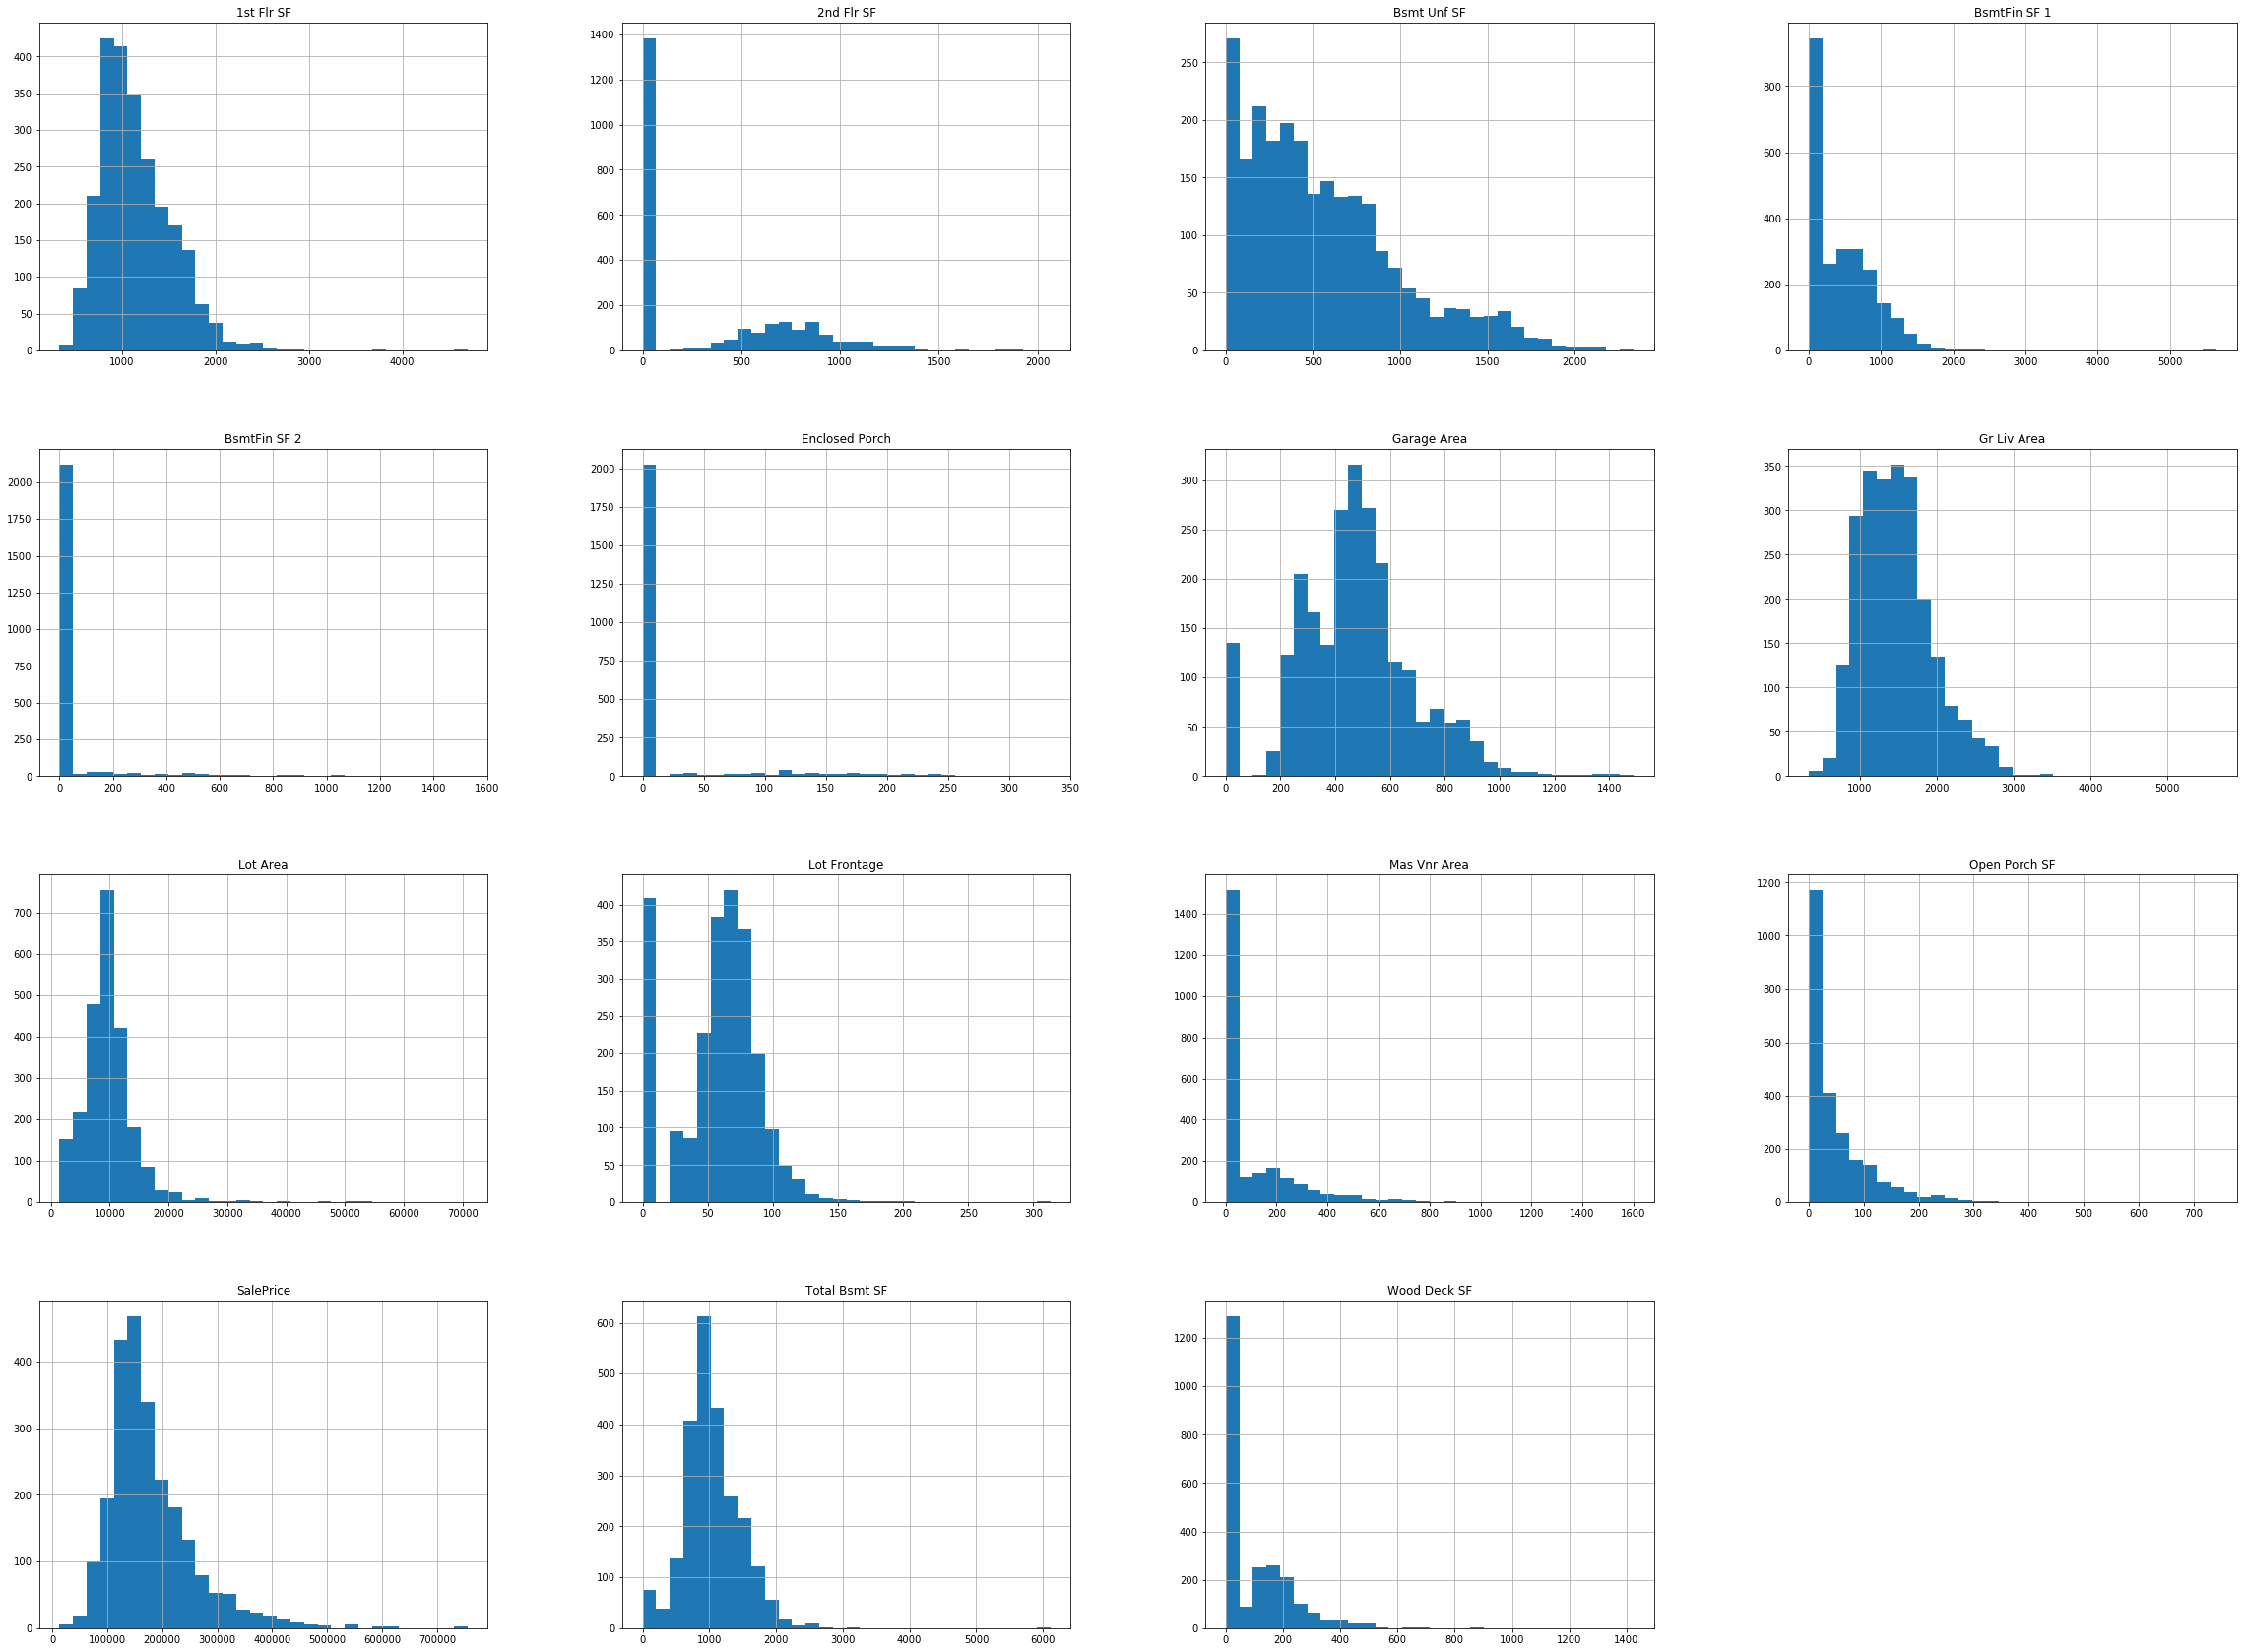

In [42]:
df_encoded[continuous].hist(bins=30, figsize=(40, 30))
plt.show()

In [43]:
# Perform log transformation.

df_encoded[continuous] = np.log1p(df_encoded[continuous])

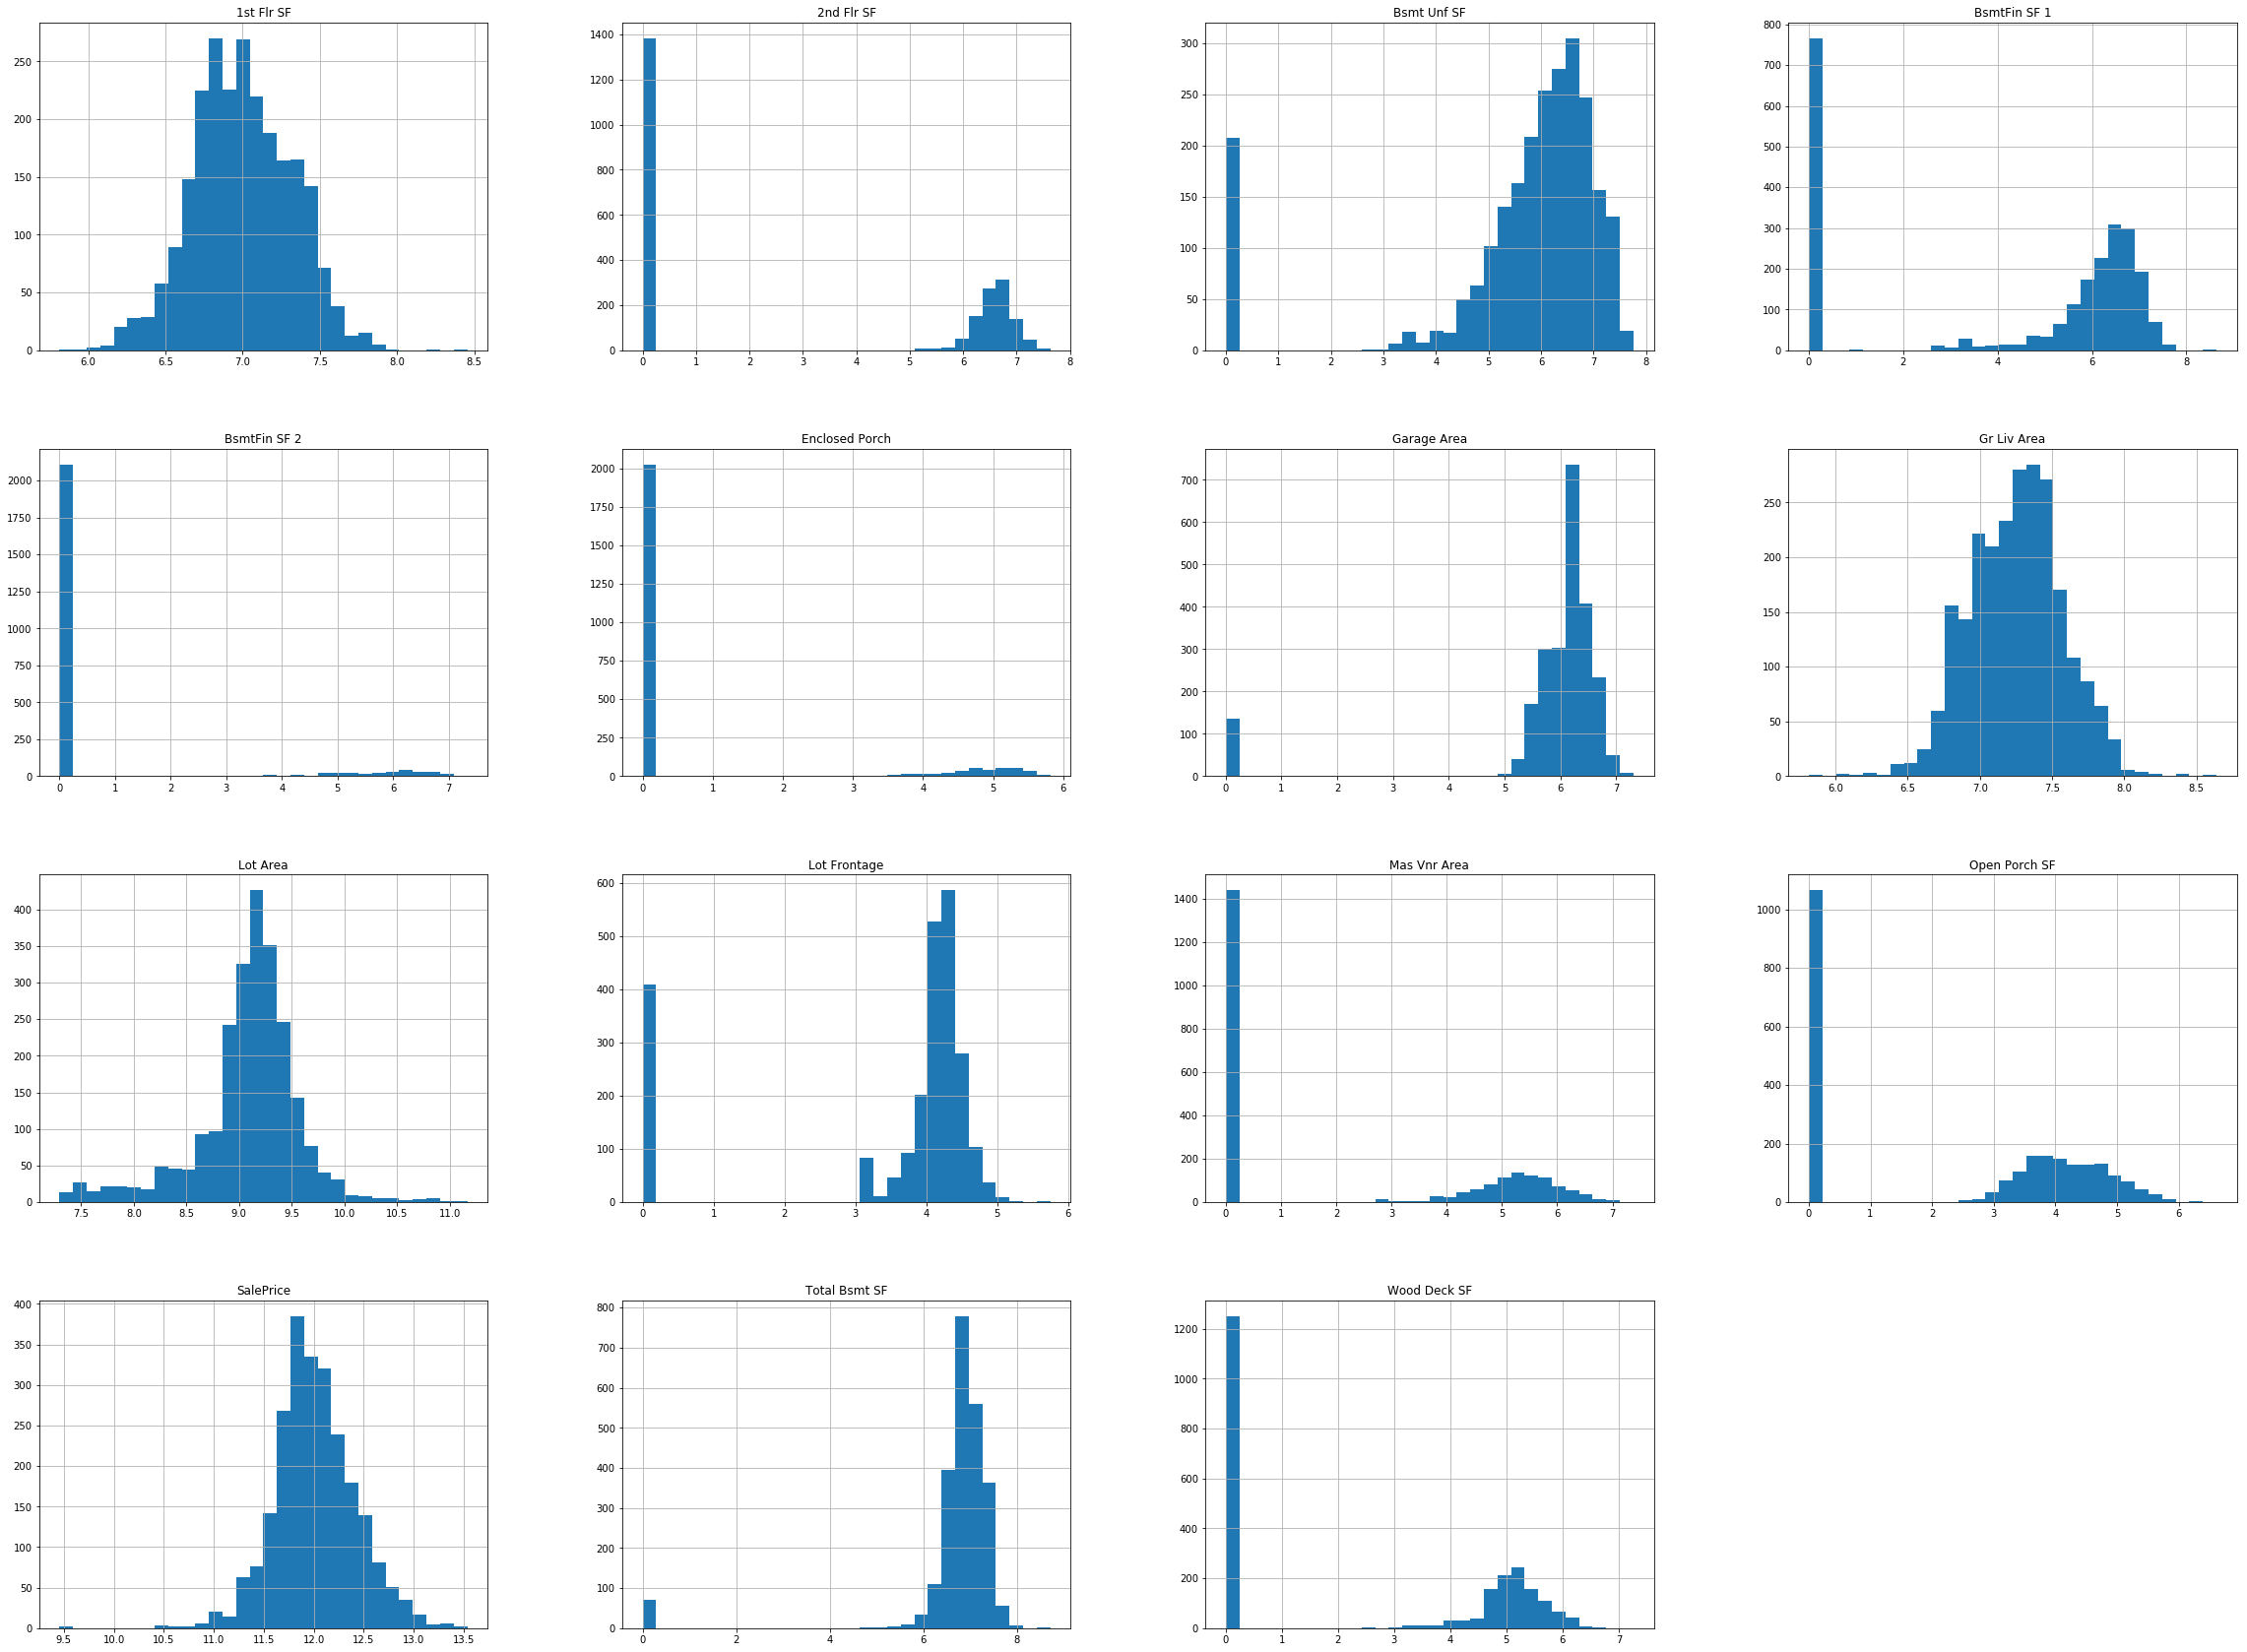

In [44]:
df_encoded[continuous].hist(bins=30, figsize=(40, 30))
plt.show()

In [45]:
df_encoded.shape

(2394, 210)

## Modelling

### 1. Simple Model
I decided to opt for a simple linear regression. 

In [46]:
X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

In [47]:
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [48]:
from sklearn.preprocessing import StandardScaler

# Calulate Baseline

X0 = X.values
y0 = y.values


X_tr0, X_te0, y_tr0, y_te0 = train_test_split(X0, y0, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_tr_rescaled_base = scaler.fit_transform(X_tr0)
X_te_rescaled_base = scaler.transform(X_te0)

mae_baseline = MAE(np.expm1(y_te0), np.expm1(np.median(X_tr0)))

mae_baseline

179329.94575799722

In [49]:
# Select features with SelectKBest

from sklearn.feature_selection import SelectKBest, f_regression

skb = SelectKBest(f_regression, k=2)

feature_arrays = skb.fit_transform(X, y)

skb_columns = X.loc[:, skb.get_support()].columns

X_skb = X[skb_columns]
X_skb.head()

,Overall Qual,Gr Liv Area
0,7.0,7.721792
1,6.0,7.362645
2,4.0,6.996681
3,5.0,7.438972
4,7.0,7.544332


In [50]:
X1 = X_skb.values
y1 = y.values

In [51]:
# Split into train/test sets

X_tr1, X_te1, y_tr1, y_te1 = train_test_split(X1, y1, test_size=0.3, random_state=0)

In [52]:
# Standardize features

X_tr_rescaled = scaler.fit_transform(X_tr1)
X_te_rescaled = scaler.transform(X_te1)

In [53]:
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [54]:
# Fit a linear regression

lr = LinearRegression()
lr.fit(X_tr_rescaled, y_tr1)
y_values = lr.predict(X_te_rescaled)

In [55]:
# Calculate MAE

mae_model1 = MAE(np.expm1(y_te1), np.expm1(y_values))

print(mae_model1)

24928.93687971385




### 2. Intermediate Model
Using a huber regression could be interesting. 

In [56]:
# Select features with SelectKBest

from sklearn.feature_selection import SelectKBest, f_regression

skb = SelectKBest(f_regression, k=19)

feature_arrays = skb.fit_transform(X, y)

skb_columns = X.loc[:, skb.get_support()].columns

X_skb2 = X[skb_columns]
X_skb2.head()

,Year Built,Year Remod/Add,Full Bath,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Foundation_PConc,Overall Qual,Exter Qual Ordinal,Bsmt Qual Ordinal,Heating QC Ordinal,Kitchen Qual Ordinal,Garage Finish Ordinal,Mas Vnr Area,1st Flr SF,Gr Liv Area,Garage Area,Open Porch SF
0,2000.0,2000.0,2.0,8.0,1.0,2000.0,2.0,1,7.0,4,4,5,4,4,0.000000,6.888572,7.721792,6.318968,4.007333
1,1951.0,1951.0,1.0,5.0,1.0,1951.0,2.0,0,6.0,3,3,3,4,2,6.259581,7.362645,7.362645,5.993961,0.000000
2,1970.0,1970.0,1.0,6.0,0.0,1970.0,1.0,0,4.0,3,3,2,3,2,4.394449,6.304449,6.996681,5.659482,0.000000
3,1959.0,1959.0,1.0,6.0,1.0,1959.0,2.0,0,5.0,3,3,4,4,3,0.000000,7.438972,7.438972,6.104793,3.663562
4,1910.0,1950.0,1.0,9.0,1.0,1960.0,1.0,0,7.0,2,3,3,3,2,0.000000,6.872128,7.544332,5.733341,0.000000


In [57]:
X2 = X_skb2.values
y2 = y.values

In [58]:
# Split into train/test sets

X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X2, y2, test_size=0.2, random_state=0)

In [59]:
# Standardize features

scaler = StandardScaler()
X_tr2_rescaled = scaler.fit_transform(X_tr2)
X_te2_rescaled = scaler.transform(X_te2)

In [60]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_error as MSE


results_2 = []

for alpha in np.logspace(-10, 10, num=100):

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr2_rescaled, y_tr2)

    results_2.append({
        'alpha': alpha,
        'train_mse': MSE(np.expm1(y_tr2), np.expm1(ridge.predict(X_tr2_rescaled))),
        'train_mae': MAE(np.expm1(y_tr2), np.expm1(ridge.predict(X_tr2_rescaled))),
        'test_mse': MSE(np.expm1(y_te2), np.expm1(ridge.predict(X_te2_rescaled))),
        'test_mae': MAE(np.expm1(y_te2), np.expm1(ridge.predict(X_te2_rescaled))),
    })
    

results_2 = pd.DataFrame(results_2)

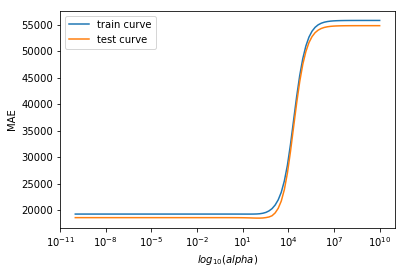

In [61]:
plt.semilogx(results_2['alpha'], results_2['train_mae'], label='train curve')
plt.semilogx(results_2['alpha'], results_2['test_mae'], label='test curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [62]:
best_result_2 = results_2.loc[results_2.test_mae.idxmin()]

print('Best alpha: {:.1e}'.format(best_result_2.alpha)) 
print('Test MSE: {:.4f}'.format(best_result_2.test_mse)) 
print('Test MAE: {:,.0f}$'.format(best_result_2.test_mae)) 

Best alpha: 1.3e+02
Test MSE: 18511.4692
Test MAE: 18,511$


&emsp; 
#### I tried to apply GridSearchCV but for whatever reason the code below result in an error. 

In [63]:
# Tried to implement it with Pipe


from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

pipe = make_pipeline (
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

param_grid = {"polynomial__features": [1,2,3],
             "ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=1, return_train_score=True) 

#grid.fit(X_tr2, y_tr2)

### 3. Complex Model
Ridge regression with all of the features. 

In [64]:
X3 = X.values
y3 = y.values

# Split into train/test sets

X_tr3, X_te3, y_tr3, y_te3 = train_test_split(X3, y3, test_size=0.3, random_state=0)

In [65]:
scaler = StandardScaler()
X_tr3_rescaled = scaler.fit_transform(X_tr3)
X_te3_rescaled = scaler.transform(X_te3)

In [66]:
results_3 = []

for alpha in np.logspace(-10, 10, num=100):

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr3_rescaled, y_tr3)

    results_3.append({
        'alpha': alpha,
        'train_mse': MSE(np.expm1(y_tr3), np.expm1(ridge.predict(X_tr3_rescaled))),
        'train_mae': MAE(np.expm1(y_tr3), np.expm1(ridge.predict(X_tr3_rescaled))),
        'test_mse': MSE(np.expm1(y_te3), np.expm1(ridge.predict(X_te3_rescaled))),
        'test_mae': MAE(np.expm1(y_te3), np.expm1(ridge.predict(X_te3_rescaled))),
    })
    

results_3 = pd.DataFrame(results_3)

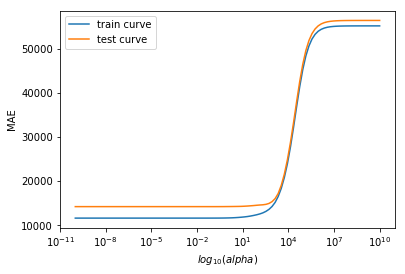

In [67]:
plt.semilogx(results_3['alpha'], results_3['train_mae'], label='train curve')
plt.semilogx(results_3['alpha'], results_3['test_mae'], label='test curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [68]:
best_result_3 = results_3.loc[results_3.test_mae.idxmin()]

print('Best alpha: {:.1e}'.format(best_result_3.alpha)) 
print('Test MSE: {:.4f}'.format(best_result_3.test_mse)) 
print('Test MAE: {:,.0f}$'.format(best_result_3.test_mae)) 

Best alpha: 1.2e-01
Test MSE: 14258.2168
Test MAE: 14,258$


&emsp; 
#### I tried to use SGDRegressor with an early stopping but it doesn't seem that it is working. 

In [69]:
from sklearn.base import clone

sgd = SGDRegressor(max_iter = 1, learning_rate = "constant", tol =np.infty, warm_start=True, 
                  penalty=None, eta0=0.0005)

gd_results =[]

minimum_val_error = float("inf")
best_epoch = None
best_model = None
#for epoch in range(1000):
    #sgd.fit(X_tr3_rescaled, y_tr3)
    #y_val_pre = sgd.predict(X_te3_rescaled)
    #val_error = MAE(y_te3, y_val_pre)
    #gd_results.append({
        #'MAE': val_error,
        #"epoch":epoch
    #})
    #if val_error < minimum_val_error:
        #minimum_val_error = val_error
        #best_epoch = epoch
        #best_model = clone(sgd)

In [70]:
#best_model.fit(X_tr3_rescaled, y_tr3)
#y_val_pre = best_model.predict(X_te3_rescaled)

#MAE3 = MAE(y_te3, y_val_pre)

In [71]:
gd_results = pd.DataFrame(gd_results)

In [72]:
#plt.plot(gd_results.epoch, gd_results.MAE)
#plt.xlabel("Epoch")
#plt.ylabel("MAE")
#plt.show()

### 4. Comparision



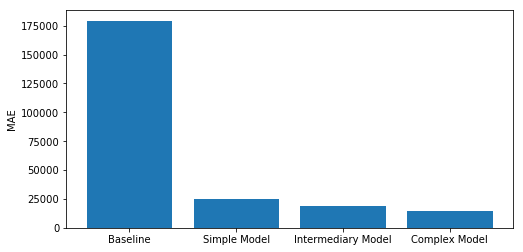

In [73]:
data_0 = [mae_baseline, mae_model1,best_result_2.test_mae, best_result_3.test_mse]
data_1 = [mae_model1,best_result_2.test_mae, best_result_3.test_mse]

labels_0 =["Baseline", "Simple Model", "Intermediary Model", "Complex Model"]
labels_1 =["Simple Model", "Intermediary Model", "Complex Model"]

plt.figure(figsize=(8,4))
plt.bar(np.arange(len(data_0)),data_0)
plt.xticks(np.arange(len(data_0)), labels_0)
plt.ylabel('MAE')
plt.show()

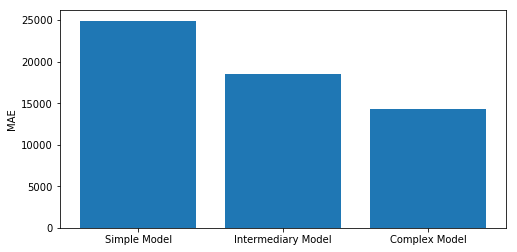

In [74]:
plt.figure(figsize=(8,4))
plt.bar(np.arange(len(data_1)),data_1)
plt.xticks(np.arange(len(data_1)), labels_1)
plt.ylabel('MAE')
plt.show()

## Predictions

I applied the same pre-processing steps used with the training sets. I also tried to be sure that the sape of the matrix is the same as the one of the trainaining set. 

In [75]:
df_test = pd.read_csv("house-prices-test.csv")

In [76]:
df_test1 = df_test.drop(["Order", "PID"], axis=1)

In [77]:
s = df_test1.select_dtypes(include='int64').columns
df_test1[s] = df_test1[s].astype("float64")

In [78]:
df_test_float=df_test1.select_dtypes(exclude=['object'])
df_test_object=df_test1.select_dtypes("object")

In [79]:
# Coulmns that can be replaced with 0.  suppose that Nan values were initally meant as 0.

data_nan = ["Lot Frontage","Mas Vnr Area", "Bsmt Full Bath", 
                "Bsmt Half Bath", "BsmtFin SF 1", "Total Bsmt SF", 
                "Bsmt Unf SF", "BsmtFin SF 2", "Garage Cars", "Garage Area"]

df_test_float.loc[:,data_nan] = df_test_float.loc[:, data_nan].replace(np.nan,0)

# Missing year built values can be replace with the mean.

df_test_float.loc[:,"Garage Yr Blt"] = df_test_float.loc[:,"Garage Yr Blt"].fillna(df_test_float.loc[:,"Garage Yr Blt"].mean(axis=0))

df_test_float.isnull().sum().sort_values(ascending=False).head(15)

/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

Yr Sold            0
Mo Sold            0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Total Bsmt SF      0
Bsmt Unf SF        0
BsmtFin SF 2       0
BsmtFin SF 1       0
Mas Vnr Area       0
Year Remod/Add     0
Year Built         0
Overall Cond       0
Overall Qual       0
dtype: int64

In [80]:
# Change features with a lot of 0s to categorical. 

df_test_float['3Ssn Porch'] = np.where(df_test_float['3Ssn Porch']>0.1, 'Yes', "No")
df_test_float['Low Qual Fin SF'] = np.where(df_test_float['Low Qual Fin SF']>0.1, 'Yes', "No")
df_test_float['Misc Val'] = np.where(df_test_float['Misc Val']>0.1, 'Yes', "No")
df_test_float['Pool Area'] = np.where(df_test_float['Pool Area']>0.1, 'Yes', "No")
df_test_float['Screen Porch'] = np.where(df_test_float['Screen Porch']>0.1, 'Yes', "No")

/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be se

In [81]:
# Drop columns that miss more than 50% of entries

df_test_object = df_test_object.drop(["Pool QC", "Misc Feature", "Alley", "Fence", "Fireplace Qu"], axis=1)

In [82]:
# By consultating the documentation I saw that I could change the NaN to the category NA.

data_NA = ["Garage Cond", "Garage Qual", "Garage Finish", 
           "Garage Type", "BsmtFin Type 2", "Bsmt Cond", "Bsmt Qual","BsmtFin Type 1", "Bsmt Exposure"]

df_test_object[data_NA]=df_test_object[data_NA].fillna("NA")

In [83]:
# By consultating the documentation I saw that I could change the NaN to the category None.

df_test_object["Mas Vnr Type"]=df_test_object["Mas Vnr Type"].fillna("None")

In [84]:
# Replace the missing value with the most frequent value of the feature. 

df_test_object["Electrical"]=df_test_object["Electrical"].fillna("SBrkr")

In [85]:
# Replace NA in some features to the most common value TA.

df_test_object[["Garage Qual", "Garage Cond", "Bsmt Cond", "Bsmt Qual"]]=df_test_object[["Garage Qual", "Garage Cond", "Bsmt Cond", "Bsmt Qual"]].replace("NA", "TA")

In [86]:
# Merging df_float and df_object together

df_test_clean = pd.concat([df_test_float, df_test_object], axis=1, join='inner')

In [87]:
# Discrete Variables

discrete = ["Year Built", "Year Remod/Add", "Bsmt Full Bath", 
            "Bsmt Half Bath", "Full Bath", "Half Bath", "TotRms AbvGrd",
            "Fireplaces", "Garage Yr Blt", "Garage Cars", "Mo Sold", "Yr Sold"]

df_test_discrete=df_test_clean[discrete]

In [88]:
# Cyclical encoding on "Mo Sold"
# Normalize values to match with the 0-2 pi cycle.

mo_normalized = 2* math.pi * df_test_discrete["Mo Sold"] / df_test_discrete["Mo Sold"].max()

df_test_discrete["Mo Sold cos"] = np.cos(mo_normalized)
df_test_discrete["Mo Sold sin"] = np.sin(mo_normalized)

df_test_discrete = df_test_discrete.drop("Mo Sold", axis=1)

/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [89]:
# Nominal Variables

nominal =['3Ssn Porch', 'Low Qual Fin SF', 'Misc Val', 'Pool Area', 'Screen Porch',
          "MS SubClass", "MS Zoning", "Street", "Land Contour", "Lot Config", 
          "Neighborhood", "Condition 1", "Condition 2", "Bldg Type", "House Style", 
          "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", 
          "Foundation", "Heating", "Central Air", "Garage Type", "Sale Type", "Sale Condition"]

df_test_nominal=df_test_clean[nominal]

In [90]:
# Change MS SubClass to string.

df_test_nominal["MS SubClass"] = df_test_nominal["MS SubClass"].astype(str)

/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [91]:
# Get Dummies

df_test_nominal = pd.get_dummies(df_test_nominal, drop_first=True)

In [92]:
# Include empty columns so that test and train shape are equal. 

df_test_nominal = df_test_nominal.reindex(columns = df_nominal.columns, fill_value=0)

In [93]:
df_test_nominal.shape

(500, 162)

In [94]:
# Ordinal Variables 

ordinal = ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond", "Exter Qual",
           "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", 
           "Heating QC", "Electrical", "Kitchen Qual", "Functional", "Garage Finish", 
           "Garage Qual", "Garage Cond", "Paved Drive"]

df_test_ordinal=df_test_clean[ordinal]

In [95]:
# Lot Shape Ordinal

lot_dict = { "Reg" : 4,
            "IR1" : 3,
            "IR2" : 2,
            "IR3" : 1}
df_test_ordinal["Lot Shape Ordinal"] = df_test_ordinal["Lot Shape"].map(lot_dict)


# Utilities Ordinal

utilities_dict = { "AllPub" : 4,
            "NoSewr" : 3,
            "NoSeWa" : 2,
            "ELO" : 1}
df_test_ordinal["Utilities Ordinal"] = df_test_ordinal["Utilities"].map(utilities_dict)


# Land Slope Ordinal

land_dict = { "Gtl" : 3,
            "Mod" : 2,
            "Sev" : 1,}
df_test_ordinal["Land Slope Ordinal"] = df_test_ordinal["Land Slope"].map(land_dict)


# Exter Qual Ordinal

exter_qual_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}
df_test_ordinal["Exter Qual Ordinal"] = df_test_ordinal["Exter Qual"].map(exter_qual_dict)


# Exter Cond Ordinal

exter_cond_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_test_ordinal["Exter Cond Ordinal"] = df_test_ordinal["Exter Cond"].map(exter_cond_dict)


# Bsmt Qual Ordinal

bsmt_qual_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_test_ordinal["Bsmt Qual Ordinal"] = df_test_ordinal["Bsmt Qual"].map(bsmt_qual_dict)


# Bsmt Cond Ordinal

bsmt_cond_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_test_ordinal["Bsmt Cond Ordinal"] = df_test_ordinal["Bsmt Cond"].map(bsmt_qual_dict)


# Bsmt Exposure Ordinal

bsmt_expo_dict = { "Gd" : 5,
                    "Av" : 4,
                    "Mn" : 3,
                      "No" : 2,
                      "NA" : 1}

df_test_ordinal["Bsmt Exposure Ordinal"] = df_test_ordinal["Bsmt Exposure"].map(bsmt_expo_dict)


# BsmtFin Type 1 Ordinal

bsmt_t1_dict = { "GLQ" : 7,
                    "ALQ" : 6,
                    "BLQ" : 5,
                    "Rec" : 4,
                    "LwQ" : 3,
                    "Unf" : 2,
                    "NA" : 1}

df_test_ordinal["BsmtFin Type 1 Ordinal"] = df_test_ordinal["BsmtFin Type 1"].map(bsmt_t1_dict)


# BsmtFin Type 2 Ordinal

bsmt_t2_dict = { "GLQ" : 7,
                    "ALQ" : 6,
                    "BLQ" : 5,
                    "Rec" : 4,
                    "LwQ" : 3,
                    "Unf" : 2,
                    "NA" : 1}

df_test_ordinal["BsmtFin Type 2 Ordinal"] = df_test_ordinal["BsmtFin Type 2"].map(bsmt_t2_dict)


# Heating QC Ordinal

heating_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_test_ordinal["Heating QC Ordinal"] = df_test_ordinal["Heating QC"].map(heating_dict)


# Electrical Ordinal

electrical_dict = { "SBrkr" : 5,
                    "FuseA" : 4,
                    "FuseF" : 3,
                      "FuseP" : 2,
                      "Mix" : 1}

df_test_ordinal["Electrical Ordinal"] = df_test_ordinal["Electrical"].map(electrical_dict)


# Kitchen Qual Ordinal

kitchen_qual_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_test_ordinal["Kitchen Qual Ordinal"] = df_test_ordinal["Kitchen Qual"].map(kitchen_qual_dict)


# Functional Ordinal

functional_dict = { "Typ" : 8,
                    "Min1" : 7,
                    "Min2" : 6,
                    "Mod" : 5,
                    "Maj1" : 4,
                    "Maj2" : 3,
                    "Sev" : 2,
                    "Sal" : 1}

df_test_ordinal["Functional Ordinal"] = df_test_ordinal["Functional"].map(functional_dict)


# Garage Finish Ordinal

garage_finish_dict = { "Fin" : 4,
                       "RFn" : 3,
                       "Unf" : 2,
                       "NA" : 1}

df_test_ordinal["Garage Finish Ordinal"] = df_test_ordinal["Garage Finish"].map(garage_finish_dict)


# Garage Qual Ordinal

garage_qual_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_test_ordinal["Garage Qual Ordinal"] = df_test_ordinal["Garage Qual"].map(garage_qual_dict)


# Garage Cond Ordinal

garage_cond_dict = { "Ex" : 5,
                    "Gd" : 4,
                    "TA" : 3,
                      "Fa" : 2,
                      "Po" : 1}

df_test_ordinal["Garage Cond Ordinal"] = df_test_ordinal["Garage Cond"].map(garage_cond_dict)


# Paved Drive Ordinal

paved_dict = { "Y" : 3,
                "P" : 2,
                "N" : 1}

df_test_ordinal["Paved Drive Ordinal"] = df_test_ordinal["Paved Drive"].map(paved_dict)

/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/samerre/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [96]:
df_test_ordinal = df_test_ordinal.drop(["Lot Shape", "Utilities", "Land Slope", "Exter Qual", "Exter Cond", "Bsmt Qual", 
                         "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", 
                         "Electrical", "Kitchen Qual", "Functional", "Garage Finish", "Garage Qual", 
                         "Garage Cond", "Paved Drive"], axis =1)

In [97]:
# Continuous Variables 

continuous = ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", 
              "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF",
              "Gr Liv Area", "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch"]

df_test_continuous=df_test[continuous]

In [98]:
df_test_encoded=pd.concat([df_test_discrete, df_test_nominal, df_test_ordinal, df_test_continuous], axis=1, join="inner")

In [99]:
# Fill remaining missing values with 0

df_test_encoded = df_test_encoded.fillna(0)

In [100]:
# Perform log transformation.

df_test_encoded[continuous] = np.log1p(df_test_encoded[continuous])

### Prediction Models

In [101]:
# Simple Model

X_test1 = df_test_encoded[["Overall Qual", "Gr Liv Area"]]
X_test1 = X_test1.values

X_tr_rescaled = scaler.fit_transform(X_tr1)
X_test_rescaled = scaler.transform(X_test1)

lr = LinearRegression()
lr.fit(X_tr_rescaled, y_tr1)
y_values_test1 = lr.predict(X_test_rescaled)
                            
y_values_test1 = np.expm1(y_values_test1)

In [102]:
predictions_simple_model = pd.DataFrame({'PID':df_test["PID"],'SalePrice':y_values_test1})
predictions_simple_model.to_csv("predictions-simple-model.csv", index=False)

In [103]:
# Intermediary Model


X_test2 = df_test_encoded[["Year Built", "Year Remod/Add", "Full Bath", "TotRms AbvGrd", "Fireplaces", 
                           "Garage Yr Blt", "Garage Cars", "Foundation_PConc", "Overall Qual", "Exter Qual Ordinal",
                           "Bsmt Qual Ordinal", "Heating QC Ordinal", "Kitchen Qual Ordinal", "Garage Finish Ordinal", 
                           "Mas Vnr Area", "1st Flr SF", "Gr Liv Area", "Garage Area", "Open Porch SF"]]

X_test2 = X_test2.values

X_tr2_rescaled = scaler.fit_transform(X_tr2)
X_test2_rescaled = scaler.transform(X_test2)

ridge = Ridge(alpha=1.3e+02)
ridge.fit(X_tr2_rescaled, y_tr2)
y_values_test2 = np.expm1(ridge.predict(X_test2_rescaled))

In [104]:
predictions_intermediate_model = pd.DataFrame({'PID':df_test["PID"],'SalePrice':y_values_test2})
predictions_intermediate_model.to_csv("predictions-intermediate-model.csv", index=False)

In [105]:
# Check if shape and columns are equal to the training set

train_cols = df_encoded.columns
test_cols = df_test_encoded.columns

train_not_test = train_cols.difference(test_cols)
train_not_test                          

Index(['SalePrice'], dtype='object')

<span style='color:red'> Complex Model perform worse than simple/intermediate model. I am not entirely sure why. It most likely has to do with the preprocessing part above, but I couldn't find the error.  </span>

In [106]:
# Complex Model

X_test3 = df_test_encoded

# Set order of columns equal to the training set
X_test3 = X_test3[X.columns]

X_test3 = X_test3.values

X_tr3_rescaled = scaler.fit_transform(X_tr3)
X_test3_rescaled = scaler.transform(X_test3)

ridge = Ridge(alpha=1.2e-01)
ridge.fit(X_tr3_rescaled, y_tr3)
y_values_test3 = np.expm1(ridge.predict(X_test3_rescaled))

In [107]:
predictions_complex_model = pd.DataFrame({'PID':df_test["PID"],'SalePrice':y_values_test3})
predictions_complex_model.to_csv("predictions-complex-model.csv", index=False)